# Klassifikation von Bildern

## Daten laden
Daten werden von folgender URL geladen(https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile
import helper
import numpy as np

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


# Konfiguration




In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%pdb

Automatic pdb calling has been turned ON


# Vorbereiten der Daten

### Normalisieren


In [3]:
def normalize(x):
    return x/np.max(x, axis = 0)

### One-hot encode


In [4]:

def one_hot_encode(x):
    arr = np.array(x)
    zeroarray = np.zeros((len(x), 10))

    for i,label in enumerate(arr):   
       zeroarray[i,label] = 1 
    return zeroarray


## Vorbereiten und Speichern der Daten


In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Check Point

In [6]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

# Build the network


In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, shape=(None,image_shape[0],image_shape[1],image_shape[2]),name="x")


def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=(None,n_classes),name="y" )


def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob" )


### Convolution und Max Pooling Layer


In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides,layer_count):
    weight = tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], int(x_tensor.get_shape()[3]), conv_num_outputs],stddev=0.1))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    

    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    conv_layer = tf.nn.relu(conv_layer)
    
    max_pool_ksize = [1, pool_ksize[0], pool_ksize[1], 1]
    max_pool_strides = [1, pool_strides[0], pool_strides[1], 1]
    maxpool = tf.nn.max_pool(conv_layer, max_pool_ksize, max_pool_strides, padding='SAME')
    
    #tf.summary.histogram(layer_count+'_maxpool_w', weight)
    #tf.summary.histogram(layer_count+'_maxpool_b', bias)
    
    return  maxpool


### Flatten Layer


In [9]:
def flatten(x_tensor):
    return tf.contrib.layers.flatten(x_tensor)

### Fully-Connected Layer


In [10]:
def fully_conn(x_tensor, num_outputs):
    return tf.contrib.layers.fully_connected(inputs=x_tensor,num_outputs=num_outputs,activation_fn=tf.nn.relu)


### Output Layer


In [11]:
def output(x_tensor, num_outputs):
    return tf.contrib.layers.fully_connected(inputs=x_tensor,num_outputs=num_outputs,activation_fn=None)

### Create Convolutional Model


In [12]:
def conv_net(x, keep_prob,cnn_layer=1):
    maxpool_layer =  conv2d_maxpool(x, 32, (2,2), (2,2), (2,2), (2,2),"1")
    
    if(cnn_layer == 2 or cnn_layer == 3):
        maxpool_layer =  conv2d_maxpool(maxpool_layer, 64, (2,2), (2,2), (2,2), (2,2),"2")
    
    if(cnn_layer == 3):
        maxpool_layer =  conv2d_maxpool(maxpool_layer, 128, (2,2), (2,2), (2,2), (2,2),"3")
    
    dropout_layer = tf.nn.dropout(x=maxpool_layer,keep_prob=keep_prob)

    flatten_layer = flatten(dropout_layer)

    fully_connected_layer = fully_conn(flatten_layer,128)
    
    fully_connected_layer = fully_conn(fully_connected_layer,64)
    
    output_layer = output(fully_connected_layer,10)
   
    return output_layer



##############################
## Build the Neural Network ##
##############################


def build_cnn(cnn_layer):
    # Remove previous weights, bias, inputs, etc..
    tf.reset_default_graph()

    # Inputs
    with tf.name_scope('inputs'):
        x = neural_net_image_input((32, 32, 3))
        y = neural_net_label_input(10)
        keep_prob = neural_net_keep_prob_input()

    # Model
    with tf.name_scope('model'):
        logits = conv_net(x, keep_prob,cnn_layer)
        logits = tf.identity(logits, name='logits')
    
    # Loss and Optimizer
    with tf.name_scope('cost'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
        optimizer = tf.train.AdamOptimizer().minimize(cost)
        tf.summary.scalar('cost', cost)

    # Accuracy
    with tf.name_scope('accuracy'):
        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
        tf.summary.scalar('accuracy', accuracy)    

    merged = tf.summary.merge_all()
    
    model = {}
    model["optimizer"] = optimizer
    model["cost"] = cost
    model["accuracy"] = accuracy
    model["merged"] = merged
    model["x"] = x
    model["y"] = y
    model["keep_prob"] = keep_prob

    return model

tests.test_conv_net(conv_net)

Neural Network Built!


# Train the Neural Network

### Single Optimization


In [13]:
def train_neural_network(session, keep_probability, feature_batch, label_batch,iteration,batchsize,model,cnn_layer):
    log_string = './output/batchsize={},rl={},keep={},cnn_layer={}'.format(batchsize, 1, keep_probability,cnn_layer)
    file_writer = tf.summary.FileWriter(log_string, sess.graph)
    train_feed_dict = {
                model["x"]: feature_batch,
                model["y"]: label_batch,
                model["keep_prob"]: keep_probability}
    summary , _= session.run([model["merged"],model["optimizer"]], feed_dict=train_feed_dict)
       
    file_writer.add_summary(summary, iteration)
    file_writer.close()



### Statistik


In [14]:
def print_stats(session, feature_batch, label_batch, model):
    loss = session.run(model["cost"], feed_dict={model["x"]: feature_batch, model["y"]: label_batch, model["keep_prob"]: 1})
    valid = sess.run(model["accuracy"], feed_dict={model["x"]: valid_features, model["y"]: valid_labels, model["keep_prob"]: 1})
    print('Loss: {:10.4f} Validation Accuracy: {:.6f}'.format(loss, valid))

### Hyperparameters


In [15]:
epochs = 15
batch_size = 128
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Es wird nur mit einem Batch und den oben gewählten Parametern trainiert.

In [ ]:
print('Checking the Training on a Single Batch...')
     
for batch_size in [64,128,256]:
    for keep_probability in [0.5,0.7]:
        for cnn_layer in [1,2,3]:
            model = build_cnn(cnn_layer)
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                for epoch in range(epochs):
                    batch_i = 1
                    for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                        train_neural_network(sess, keep_probability, batch_features, batch_labels,epoch,batch_size,model,cnn_layer)
                    print('Epoch {:>2}, CIFAR-10 Batch {}:  ,Batch-Size {},Keep-Probability {},CNN-Layer {} '.format(epoch + 1, batch_i, batch_size,keep_probability,cnn_layer), end='')
                    print_stats(sess, batch_features, batch_labels, model)
        


### Fully Train the Model
Mit allen Batches trainieren.

In [18]:
save_model_path = './image_classification'

print('Training...')
for batch_size in [64]:
    for keep_probability in [0.7]:
        for cnn_layer in [1]:
            model = build_cnn(cnn_layer)
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                
                for epoch in range(epochs):
                    # Loop over all batches
                    n_batches = 5
                    for batch_i in range(1, n_batches + 1):
                        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                            train_neural_network(sess, keep_probability, batch_features, batch_labels,epoch*batch_i+1,batch_size,model,cnn_layer)
                        print('Epoch {:>2}, CIFAR-10 Batch {}:  ,Batch-Size {},Keep-Probability {},CNN-Layer {} '.format(epoch + 1, batch_i, batch_size,keep_probability,cnn_layer), end='')
                        print_stats(sess, batch_features, batch_labels, model)
            
                # Save Model
                saver = tf.train.Saver()
                save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     2.0905 Validation Accuracy: 0.319200
Epoch  1, CIFAR-10 Batch 2:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     1.7870 Validation Accuracy: 0.388800
Epoch  1, CIFAR-10 Batch 3:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     1.4977 Validation Accuracy: 0.408000
Epoch  1, CIFAR-10 Batch 4:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     1.5098 Validation Accuracy: 0.467400
Epoch  1, CIFAR-10 Batch 5:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     1.5037 Validation Accuracy: 0.487600
Epoch  2, CIFAR-10 Batch 1:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     1.5949 Validation Accuracy: 0.491200
Epoch  2, CIFAR-10 Batch 2:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     1.3417 Validation Accuracy: 0.501400
Epoch  2, CIFAR-10 Batch 3:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     1.1489 Validation Accuracy: 0.509

Epoch 14, CIFAR-10 Batch 2:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     0.6412 Validation Accuracy: 0.621200
Epoch 14, CIFAR-10 Batch 3:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     0.6233 Validation Accuracy: 0.618400
Epoch 14, CIFAR-10 Batch 4:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     0.6260 Validation Accuracy: 0.624000
Epoch 14, CIFAR-10 Batch 5:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     0.7742 Validation Accuracy: 0.626200
Epoch 15, CIFAR-10 Batch 1:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     0.9474 Validation Accuracy: 0.621000
Epoch 15, CIFAR-10 Batch 2:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     0.6427 Validation Accuracy: 0.621800
Epoch 15, CIFAR-10 Batch 3:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     0.6386 Validation Accuracy: 0.619800
Epoch 15, CIFAR-10 Batch 4:  ,Batch-Size 64,Keep-Probability 0.7,CNN-Layer 1 Loss:     0.5945 Validation Accuracy: 0.625600
Epoch 15

# Checkpoint
Das Model wird persistiert.
## Test Model
Das Model wird mit den Testdaten getestet.

Testing Accuracy: 0.6361464968152867



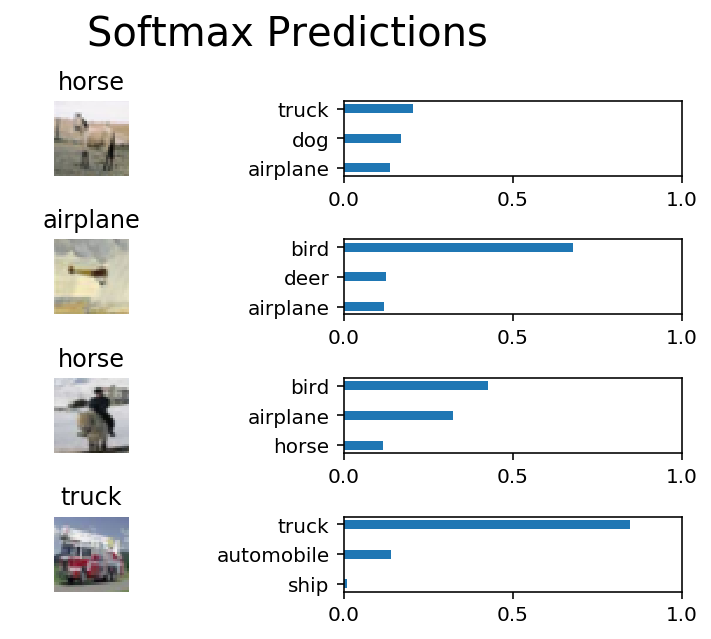

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
               

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('inputs/x:0')
        loaded_y = loaded_graph.get_tensor_by_name('inputs/y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('inputs/keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('model/logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy/accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()